In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from signed_distance import *
from nlp_builder import NLPBuilder
from nlp_solver import SQPSolver
from functools import partial

In [2]:
from pybullet_suite import *

pybullet build time: Dec 14 2022 00:46:04


In [2]:
# problem
num_steps = 10
center_obs = jnp.array([0, 0.1])
r_obs = 0.2

dim_robot = 2
r_robot = 0.1
safe_dist = 0.1

q_init = jnp.array([-1, -1])
q_goal = jnp.array([1, 1])
qu, ql = jnp.full(2, 1.1), jnp.full(2, -1.1)

In [3]:
#util functions
def to_mat(x):
    return x.reshape(-1, dim_robot)
def to_vec(mat):
    return mat.flatten()
def at_timestep(i, x):
    return to_mat(x)[i]
def to_vel(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

In [103]:
# define robot
x_robot = r_robot*jnp.cos(jnp.linspace(0, jnp.pi*2, 10))
y_robot = r_robot*jnp.sin(jnp.linspace(0, jnp.pi*2, 10))
p_robot = jnp.vstack([x_robot, y_robot]).T

In [5]:
# functions
obs = Circle(center_obs, r_obs)
env = EnvSDF((obs,), safe_dist) # exclude r_robot in safe_dist
assign_points = lambda q: p_robot + q
assign_points_path = lambda x: jnp.vstack(jax.vmap(assign_points)(to_mat(x)))

state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)
penetration = lambda x: env.penetrations(assign_points_path(x))
def min_dist_cost(x):
    v = to_vel(x)
    return v @ v + penetration(x)

xl = jnp.tile(ql, num_steps)
xu = jnp.tile(qu, num_steps)
x0 = jnp.zeros_like(xu)

#jnp.linspace(q_init, q_goal, num_steps).flatten()

In [6]:
#build NLP problem 
dim = num_steps * dim_robot
nlp = NLPBuilder(dim=dim)
nlp.set_f(min_dist_cost)
nlp.add_eq_const(state_init, q_init, est_sparsity=True)
nlp.add_eq_const(state_goal, q_goal, est_sparsity=True)
#nlp.add_eq_const(penetration, 0., est_sparsity=False)
nlp.set_state_bound(xl, xu)

In [7]:
solver = SQPSolver.from_builder(nlp, sparsity=True)
solver.prebuild(mode="BFGS")

In [9]:
import time
tic = time.time()
xsol = solver.solve(x0, tol=0.03, verbose=True, save_history=True)
elapsed = time.time() - tic
print(elapsed)

0: grad:7.6350 | viol:0.2000 | alpha:0.8000
1: grad:4.9228 | viol:0.0000 | alpha:1.0000
2: grad:3.2376 | viol:0.0000 | alpha:0.8000
3: grad:2.2577 | viol:0.0000 | alpha:0.5120
4: grad:2.1105 | viol:0.0000 | alpha:0.6400
5: grad:1.2675 | viol:0.0000 | alpha:0.6400
6: grad:1.3628 | viol:0.0000 | alpha:0.6400
7: grad:0.9948 | viol:0.0000 | alpha:0.6400
8: grad:0.9429 | viol:0.0000 | alpha:0.6400
9: grad:0.6595 | viol:0.0000 | alpha:0.8000
10: grad:1.1490 | viol:0.0000 | alpha:0.5120
11: grad:0.4690 | viol:0.0000 | alpha:1.0000
12: grad:0.5039 | viol:0.0000 | alpha:1.0000
13: grad:0.4232 | viol:0.0000 | alpha:0.8000
14: grad:0.4902 | viol:0.0000 | alpha:1.0000
15: grad:0.3860 | viol:0.0000 | alpha:0.8000
16: grad:0.4537 | viol:0.0000 | alpha:1.0000
17: grad:0.7614 | viol:0.0000 | alpha:0.6400
18: grad:0.2934 | viol:0.0000 | alpha:1.0000
19: grad:0.3716 | viol:0.0000 | alpha:1.0000
20: grad:0.4169 | viol:0.0000 | alpha:1.0000
21: grad:0.9298 | viol:0.0000 | alpha:0.4096
22: grad:1.0204 | vi

Array([-1.209017,  6.443963, -1.209017,  6.443963, -1.209017,  6.443963,
       -1.209017,  6.443963, -1.209017,  6.443963, -1.209017,  6.443963,
       -1.209017,  6.443963, -1.209017,  6.443963, -1.209017,  6.443963,
       -1.209017,  6.443963], dtype=float32)

In [49]:
xs = [s.x for s in solver.states]
lag_grads = [np.linalg.norm(s.lag_grad) for s in solver.states]
len(xs)

56

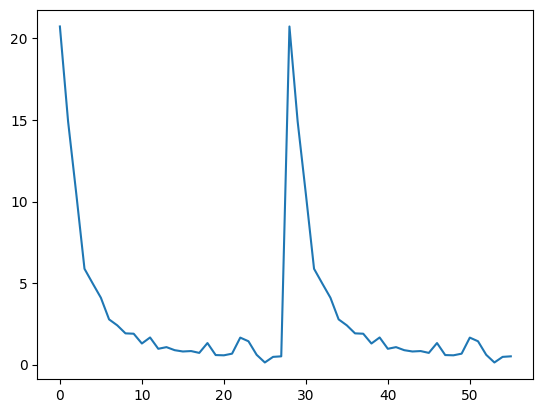

In [50]:
plt.plot(lag_grads)

In [106]:
i= 0

22


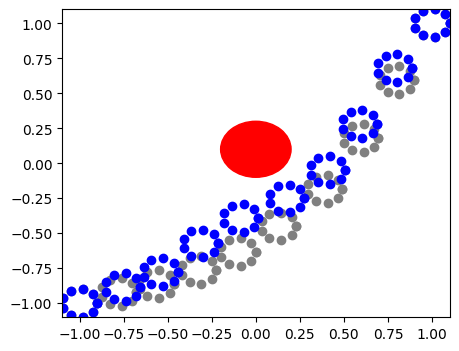

In [128]:
import matplotlib.pyplot as plt
qs = to_mat(xs[i])

fig, ax = plt.subplots(figsize=[5,4])
robots = []
if i>=1:
    qs_prev = to_mat(xs[i-1])
    ax.scatter(*assign_points_path(qs_prev).T, color='gray')
ax.scatter(*assign_points_path(qs).T, color='blue')

circle = plt.Circle(center_obs, r_obs, color='r')
xlim, ylim = jnp.vstack([ql, qu]).T
ax.add_patch(circle)
#ax = plt.scatter(*qs.T)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
i += 1
print(i)

